# Load the Labels

In [25]:
#import pandas as pd

#df = pd.read_csv('input-1300.csv') # Read the label
#print(df.head())
#df_shuffled = df.sample(frac=1)
#df_shuffled.to_csv('temp-groundtruth.csv', index=False)
# print(df_shuffled.head())
#df_llm = df_shuffled[['Project', 'Class']]
#df_llm['Pattern Predicted'] = None
#df_llm.to_csv('temp-llmres.csv', index=False)

# Use LLM via API (deprecated)
## DeepSeek
There is something wrong with LLM APIs, we have to do it one by one :-(

In [ ]:
# Please install OpenAI SDK first: `pip3 install openai`
#import os
#from openai import OpenAI

#client = OpenAI(api_key=os.environ.get('DEEPSEEK_API_KEY'), base_url="https://api.deepseek.com")

#response = client.chat.completions.create(
#    model="deepseek-chat",
#    messages=[
#        {"role": "system", "content": "You are a helpful assistant"},
#        {"role": "user", "content": "Hello"},
#    ],
#    stream=False
#)

#print(response.choices[0].message.content)

# Experiment Results

In [47]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import json

class DesignPatternAnalyzer:
    def __init__(self, ground_truth_file, predictions_file):
        """
        Initialize analyzer with ground truth and prediction files.
        
        Args:
            ground_truth_file: Path to CSV with ground truth annotations
            predictions_file: Path to CSV with model predictions
        """
        # Read the data
        self.ground_truth = pd.read_csv(ground_truth_file)
        self.predictions = pd.read_csv(predictions_file)
        
        # Clean column names and handle missing values
        self._prepare_data()
        
        # Initialize metrics storage
        self.metrics = {}
        self.confusion_matrices = {}
        
    def _prepare_data(self):
        """Prepare and clean the data."""
        # Clean column names
        self.ground_truth.columns = [col.strip() for col in self.ground_truth.columns]
        self.predictions.columns = [col.strip() for col in self.predictions.columns]
        
        # Ensure Class column exists
        if 'Class' not in self.ground_truth.columns:
            raise ValueError("Ground truth must contain 'Class' column")
        if 'Class' not in self.predictions.columns:
            raise ValueError("Predictions must contain 'Class' column")
        
        # Pattern column names
        self.truth_col = 'Pattern'
        self.pred_col = 'Pattern Predicted'
        
        # Handle missing values
        self.ground_truth[self.truth_col] = self.ground_truth[self.truth_col].fillna('None')
        self.predictions[self.pred_col] = self.predictions[self.pred_col].fillna('None')
        
        # Merge data for comparison
        """
        self.merged_data = pd.merge(
            self.ground_truth[['Project', 'Class', self.truth_col]],
            self.predictions[['Project', 'Class', self.pred_col]],
            on=['Project', 'Class'],
            how='inner',
            suffixes=('_truth', '_pred')
        )
        """
        self.merged_data = pd.DataFrame({
            'Project': self.ground_truth['Project'],
            'Class': self.ground_truth['Class'],
            self.truth_col: self.ground_truth[self.truth_col],
            self.pred_col: self.predictions[self.pred_col]
        })
        print(self.merged_data.head())
        
        print(f"Total samples analyzed: {len(self.merged_data)}")
        
    def compute_overall_metrics(self):
        """Compute overall classification metrics."""
        y_true = self.merged_data[self.truth_col]
        y_pred = self.merged_data[self.pred_col]
        
        # Get all unique classes
        all_classes = sorted(set(y_true.unique()) | set(y_pred.unique()))
        
        # Compute metrics
        accuracy = accuracy_score(y_true, y_pred)
        
        # For multi-class, use weighted average
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=all_classes)
        
        # Store results
        self.metrics['overall'] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'n_samples': len(y_true)
        }
        self.confusion_matrices['overall'] = {
            'matrix': cm,
            'classes': all_classes
        }
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm,
            'classes': all_classes
        }
    
    def compute_pattern_wise_metrics(self):
        """Compute metrics for each pattern individually."""
        y_true = self.merged_data[self.truth_col]
        y_pred = self.merged_data[self.pred_col]
        
        # Get all patterns
        patterns = sorted(set(y_true.unique()) | set(y_pred.unique()))
        pattern_metrics = {}
        
        for pattern in patterns:
            # Convert to binary classification for this pattern
            y_true_binary = (y_true == pattern).astype(int)
            y_pred_binary = (y_pred == pattern).astype(int)
            
            # Skip if no positive samples
            if sum(y_true_binary) == 0:
                continue
            
            # Compute metrics
            tp = sum((y_true_binary == 1) & (y_pred_binary == 1))
            fp = sum((y_true_binary == 0) & (y_pred_binary == 1))
            fn = sum((y_true_binary == 1) & (y_pred_binary == 0))
            tn = sum((y_true_binary == 0) & (y_pred_binary == 0))
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            support = sum(y_true_binary)
            
            pattern_metrics[pattern] = {
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'support': int(support),
                'tp': int(tp),
                'fp': int(fp),
                'fn': int(fn),
                'tn': int(tn)
            }
        
        self.metrics['pattern_wise'] = pattern_metrics
        return pattern_metrics
    
    def compute_llm_comparison_metrics(self, llm_names):
        """Compare multiple LLMs if predictions from different models are provided."""
        # Assuming predictions file has columns for different LLMs
        # Adjust based on your actual data structure
        llm_metrics = {}
        
        for llm in llm_names:
            if llm in self.predictions.columns:
                y_pred_llm = self.predictions[llm]
                # Merge with ground truth
                merged_llm = pd.merge(
                    self.ground_truth[['Class', self.truth_col]],
                    self.predictions[['Class', llm]],
                    on='Class',
                    how='inner'
                )
                
                y_true = merged_llm[self.truth_col]
                y_pred = merged_llm[llm]
                
                accuracy = accuracy_score(y_true, y_pred)
                precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
                recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
                f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
                
                llm_metrics[llm] = {
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1_score': f1,
                    'n_samples': len(y_true)
                }
        
        self.metrics['llm_comparison'] = llm_metrics
        return llm_metrics
    
    def analyze_error_types(self):
        """Analyze specific types of errors."""
        error_analysis = defaultdict(int)
        
        for idx, row in self.merged_data.iterrows():
            true = row[self.truth_col]
            pred = row[self.pred_col]
            
            if true != pred:
                error_type = f"{true}_to_{pred}"
                error_analysis[error_type] += 1
        
        # Sort by frequency
        error_analysis = dict(sorted(error_analysis.items(), 
                                   key=lambda x: x[1], reverse=True))
        
        self.metrics['error_analysis'] = error_analysis
        return error_analysis
    
    def hallucination_analysis(self):
        """Analyze hallucination cases (predicting patterns that don't exist)."""
        # Get patterns that exist in ground truth
        valid_patterns = set(self.ground_truth[self.truth_col].unique())
        
        hallucination_cases = []
        for pattern in self.predictions[self.pred_col].unique():
            if pattern not in valid_patterns and pattern != 'None':
                count = sum(self.predictions[self.pred_col] == pattern)
                hallucination_cases.append((pattern, count))
        
        # Sort by count
        hallucination_cases.sort(key=lambda x: x[1], reverse=True)
        
        self.metrics['hallucination'] = hallucination_cases
        return hallucination_cases
    
    def plot_confusion_matrix(self, save_path=None):
        """Plot confusion matrix."""
        cm_data = self.confusion_matrices['overall']
        cm = cm_data['matrix']
        classes = cm_data['classes']
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=classes, yticklabels=classes)
        plt.title('Confusion Matrix - Design Pattern Detection')
        plt.xlabel('Predicted Pattern')
        plt.ylabel('True Pattern')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        return plt
    
    def plot_pattern_performance(self, save_path=None):
        """Plot performance metrics for each pattern."""
        if 'pattern_wise' not in self.metrics:
            self.compute_pattern_wise_metrics()
        
        pattern_metrics = self.metrics['pattern_wise']
        
        # Prepare data for plotting
        patterns = []
        precisions = []
        recalls = []
        f1s = []
        supports = []
        
        for pattern, metrics in pattern_metrics.items():
            patterns.append(pattern)
            precisions.append(metrics['precision'])
            recalls.append(metrics['recall'])
            f1s.append(metrics['f1_score'])
            supports.append(metrics['support'])
        
        # Create DataFrame for easier plotting
        df = pd.DataFrame({
            'Pattern': patterns,
            'Precision': precisions,
            'Recall': recalls,
            'F1-Score': f1s,
            'Support': supports
        })
        
        # Sort by F1-Score
        df = df.sort_values('F1-Score', ascending=True)
        
        # Plot
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # F1-Scores
        ax1 = axes[0, 0]
        colors = plt.cm.viridis(df['F1-Score'] / df['F1-Score'].max())
        ax1.barh(df['Pattern'], df['F1-Score'], color=colors)
        ax1.set_xlabel('F1-Score')
        ax1.set_title('F1-Scores by Pattern')
        ax1.axvline(x=0.5, color='r', linestyle='--', alpha=0.5)
        
        # Precision vs Recall
        ax2 = axes[0, 1]
        scatter = ax2.scatter(df['Precision'], df['Recall'], 
                             s=df['Support']*10, alpha=0.6)
        ax2.set_xlabel('Precision')
        ax2.set_ylabel('Recall')
        ax2.set_title('Precision vs Recall (size = support)')
        ax2.grid(True, alpha=0.3)
        
        # Add pattern labels to some points
        for i, pattern in enumerate(df['Pattern']):
            if df['Support'].iloc[i] > 10:  # Label only patterns with sufficient support
                ax2.annotate(pattern, (df['Precision'].iloc[i], df['Recall'].iloc[i]),
                           fontsize=8, alpha=0.7)
        
        # Support distribution
        ax3 = axes[1, 0]
        ax3.bar(df['Pattern'], df['Support'])
        ax3.set_xlabel('Pattern')
        ax3.set_ylabel('Number of Instances')
        ax3.set_title('Support Distribution')
        ax3.tick_params(axis='x', rotation=45)
        
        # All metrics comparison
        ax4 = axes[1, 1]
        x = np.arange(len(df['Pattern']))
        width = 0.25
        ax4.bar(x - width, df['Precision'], width, label='Precision')
        ax4.bar(x, df['Recall'], width, label='Recall')
        ax4.bar(x + width, df['F1-Score'], width, label='F1-Score')
        ax4.set_xlabel('Pattern')
        ax4.set_ylabel('Score')
        ax4.set_title('Metrics Comparison')
        ax4.set_xticks(x)
        ax4.set_xticklabels(df['Pattern'], rotation=45, ha='right')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.suptitle('Design Pattern Detection Performance Analysis', fontsize=16)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        return df
    
    def generate_report(self, output_file='analysis_report.json'):
        """Generate comprehensive JSON report."""
        report = {
            'overview': {
                'total_samples': len(self.merged_data),
                'unique_patterns': len(set(self.merged_data[self.truth_col].unique())),
                'date_generated': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
            },
            'overall_metrics': self.metrics.get('overall', {}),
            'pattern_wise_metrics': self.metrics.get('pattern_wise', {}),
            'error_analysis': self.metrics.get('error_analysis', {}),
            'hallucination_analysis': self.metrics.get('hallucination', []),
            'confusion_matrix_info': {
                'classes': self.confusion_matrices.get('overall', {}).get('classes', []),
                'matrix_shape': self.confusion_matrices.get('overall', {}).get('matrix', np.array([])).shape
            }
        }
        
        with open(output_file, 'w') as f:
            json.dump(report, f, indent=2, default=str)
        
        print(f"Report saved to {output_file}")
        return report
    
    def print_summary(self):
        """Print a summary of the analysis."""
        if 'overall' not in self.metrics:
            self.compute_overall_metrics()
        
        if 'pattern_wise' not in self.metrics:
            self.compute_pattern_wise_metrics()
        
        print("=" * 60)
        print("DESIGN PATTERN DETECTION ANALYSIS SUMMARY")
        print("=" * 60)
        
        # Overall metrics
        overall = self.metrics['overall']
        print(f"\n📊 OVERALL METRICS:")
        print(f"   Accuracy:  {overall['accuracy']:.3f}")
        print(f"   Precision: {overall['precision']:.3f}")
        print(f"   Recall:    {overall['recall']:.3f}")
        print(f"   F1-Score:  {overall['f1_score']:.3f}")
        print(f"   Samples:   {overall['n_samples']}")
        
        # Top performing patterns
        print(f"\n🏆 TOP PERFORMING PATTERNS (by F1-Score):")
        pattern_metrics = self.metrics['pattern_wise']
        sorted_patterns = sorted(pattern_metrics.items(), 
                               key=lambda x: x[1]['f1_score'], reverse=True)
        
        for i, (pattern, metrics) in enumerate(sorted_patterns[:5]):
            if metrics['support'] > 0:
                print(f"   {i+1}. {pattern:20} F1: {metrics['f1_score']:.3f} "
                      f"(P: {metrics['precision']:.3f}, R: {metrics['recall']:.3f}) "
                      f"Support: {metrics['support']}")
        
        # Worst performing patterns
        print(f"\n⚠️  WORST PERFORMING PATTERNS (by F1-Score):")
        for i, (pattern, metrics) in enumerate(sorted_patterns[-5:]):
            if metrics['support'] > 0:
                print(f"   {i+1}. {pattern:20} F1: {metrics['f1_score']:.3f} "
                      f"(P: {metrics['precision']:.3f}, R: {metrics['recall']:.3f}) "
                      f"Support: {metrics['support']}")
        
        # Error analysis
        if 'error_analysis' in self.metrics:
            print(f"\n🔍 TOP 5 MOST COMMON ERRORS:")
            errors = list(self.metrics['error_analysis'].items())
            for i, (error, count) in enumerate(errors[:5]):
                print(f"   {i+1}. {error:30} Count: {count}")
        
        # Hallucination analysis
        if 'hallucination' in self.metrics and self.metrics['hallucination']:
            print(f"\n🎭 HALLUCINATION ANALYSIS:")
            total_hallucinations = sum(count for _, count in self.metrics['hallucination'])
            print(f"   Total hallucinated patterns: {total_hallucinations}")
            for pattern, count in self.metrics['hallucination'][:3]:
                print(f"   - '{pattern}' predicted {count} times (but doesn't exist in ground truth)")

# Example usage function
def work(model):
    """
    Example of how to use the DesignPatternAnalyzer.
    
    Assuming you have:
    - ground_truth.csv (with columns: Project, Class, Pattern)
    - predictions.csv (with columns: Project, Class, PredictedPattern)
    """
    
    # Initialize analyzer
    analyzer = DesignPatternAnalyzer(
        ground_truth_file='temp-groundtruth.csv',  # Your ground truth file
        predictions_file='temp-llmres-' + model + '.csv'    # Your predictions file
    )
    
    # Compute all metrics
    print("Computing overall metrics...")
    overall_metrics = analyzer.compute_overall_metrics()
    
    print("\nComputing pattern-wise metrics...")
    pattern_metrics = analyzer.compute_pattern_wise_metrics()
    
    print("\nAnalyzing error types...")
    error_analysis = analyzer.analyze_error_types()
    
    print("\nChecking for hallucination...")
    hallucination = analyzer.hallucination_analysis()
    
    # Generate visualizations
    print("\nGenerating visualizations...")
    
    # Confusion matrix
    analyzer.plot_confusion_matrix(save_path='confusion_matrix_' + model + '.png')
    
    # Pattern performance plot
    performance_df = analyzer.plot_pattern_performance(save_path='pattern_performance_' + model + '.png')
    
    # Print summary
    analyzer.print_summary()
    
    # Generate comprehensive report
    report = analyzer.generate_report(output_file='design_pattern_analysis_report_' + model + '.json')
    
    # Also save detailed metrics to CSV
    if pattern_metrics:
        metrics_df = pd.DataFrame.from_dict(pattern_metrics, orient='index')
        metrics_df = metrics_df.sort_values('f1_score', ascending=False)
        metrics_df.to_csv('pattern_detailed_metrics_' + model + '.csv')
        print("\nDetailed metrics saved to pattern_detailed_metrics_" + model + ".csv")
    
    return analyzer

# Additional utility functions
def compare_multiple_experiments(experiments_dict):
    """
    Compare multiple experiments.
    
    Args:
        experiments_dict: Dictionary of {experiment_name: analyzer_object}
    """
    comparison_data = []
    
    for exp_name, analyzer in experiments_dict.items():
        if 'overall' in analyzer.metrics:
            metrics = analyzer.metrics['overall']
            comparison_data.append({
                'Experiment': exp_name,
                'Accuracy': metrics['accuracy'],
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1_score'],
                'Samples': metrics['n_samples']
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    x = np.arange(len(comparison_df))
    width = 0.2
    
    plt.bar(x - 1.5*width, comparison_df['Accuracy'], width, label='Accuracy')
    plt.bar(x - 0.5*width, comparison_df['Precision'], width, label='Precision')
    plt.bar(x + 0.5*width, comparison_df['Recall'], width, label='Recall')
    plt.bar(x + 1.5*width, comparison_df['F1-Score'], width, label='F1-Score')
    
    plt.xlabel('Experiment')
    plt.ylabel('Score')
    plt.title('Comparison of Different Experiments')
    plt.xticks(x, comparison_df['Experiment'], rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('experiment_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return comparison_df

def analyze_statistical_significance(analyzer1, analyzer2, pattern=None):
    """
    Perform McNemar's test for statistical significance.
    """
    from statsmodels.stats.contingency_tables import mcnemar
    
    # Merge predictions from both analyzers
    merged = pd.merge(
        analyzer1.merged_data[['Class', 'Pattern_pred']].rename(columns={'Pattern_pred': 'pred1'}),
        analyzer2.merged_data[['Class', 'Pattern_pred']].rename(columns={'Pattern_pred': 'pred2'}),
        on='Class'
    )
    
    # Merge with ground truth
    merged = pd.merge(
        merged,
        analyzer1.ground_truth[['Class', 'Pattern']],
        on='Class'
    )
    
    if pattern:
        # Convert to binary for specific pattern
        merged['truth_binary'] = (merged['Pattern'] == pattern).astype(int)
        merged['pred1_binary'] = (merged['pred1'] == pattern).astype(int)
        merged['pred2_binary'] = (merged['pred2'] == pattern).astype(int)
        
        # Create contingency table
        table = np.zeros((2, 2))
        table[0, 0] = sum((merged['pred1_binary'] == 1) & (merged['pred2_binary'] == 1))
        table[0, 1] = sum((merged['pred1_binary'] == 1) & (merged['pred2_binary'] == 0))
        table[1, 0] = sum((merged['pred1_binary'] == 0) & (merged['pred2_binary'] == 1))
        table[1, 1] = sum((merged['pred1_binary'] == 0) & (merged['pred2_binary'] == 0))
    else:
        # For overall accuracy
        merged['correct1'] = (merged['pred1'] == merged['Pattern']).astype(int)
        merged['correct2'] = (merged['pred2'] == merged['Pattern']).astype(int)
        
        table = np.zeros((2, 2))
        table[0, 0] = sum((merged['correct1'] == 1) & (merged['correct2'] == 1))
        table[0, 1] = sum((merged['correct1'] == 1) & (merged['correct2'] == 0))
        table[1, 0] = sum((merged['correct1'] == 0) & (merged['correct2'] == 1))
        table[1, 1] = sum((merged['correct1'] == 0) & (merged['correct2'] == 0))
    
    # Perform McNemar's test
    result = mcnemar(table, exact=True)
    
    print("McNemar's Test Results:")
    print(f"  Contingency Table:\n{table}")
    print(f"  Statistic: {result.statistic}")
    print(f"  p-value: {result.pvalue}")
    
    if result.pvalue < 0.05:
        print("  Result: Significant difference (p < 0.05)")
    else:
        print("  Result: No significant difference")
    
    return result

             Project                  Class        Pattern Pattern Predicted
0            ChenSun              Statement           None              None
1              dozer  BaseSampleBeanFactory  FactoryMethod     FactoryMethod
2  graph-collections    SpatialIndexVisitor        Visitor           Visitor
3                api      SingletonProvider      Singleton         Singleton
4            thredds          Nc4prototypes      Prototype         Prototype
Total samples analyzed: 1300
Computing overall metrics...

Computing pattern-wise metrics...

Analyzing error types...

Checking for hallucination...

Generating visualizations...


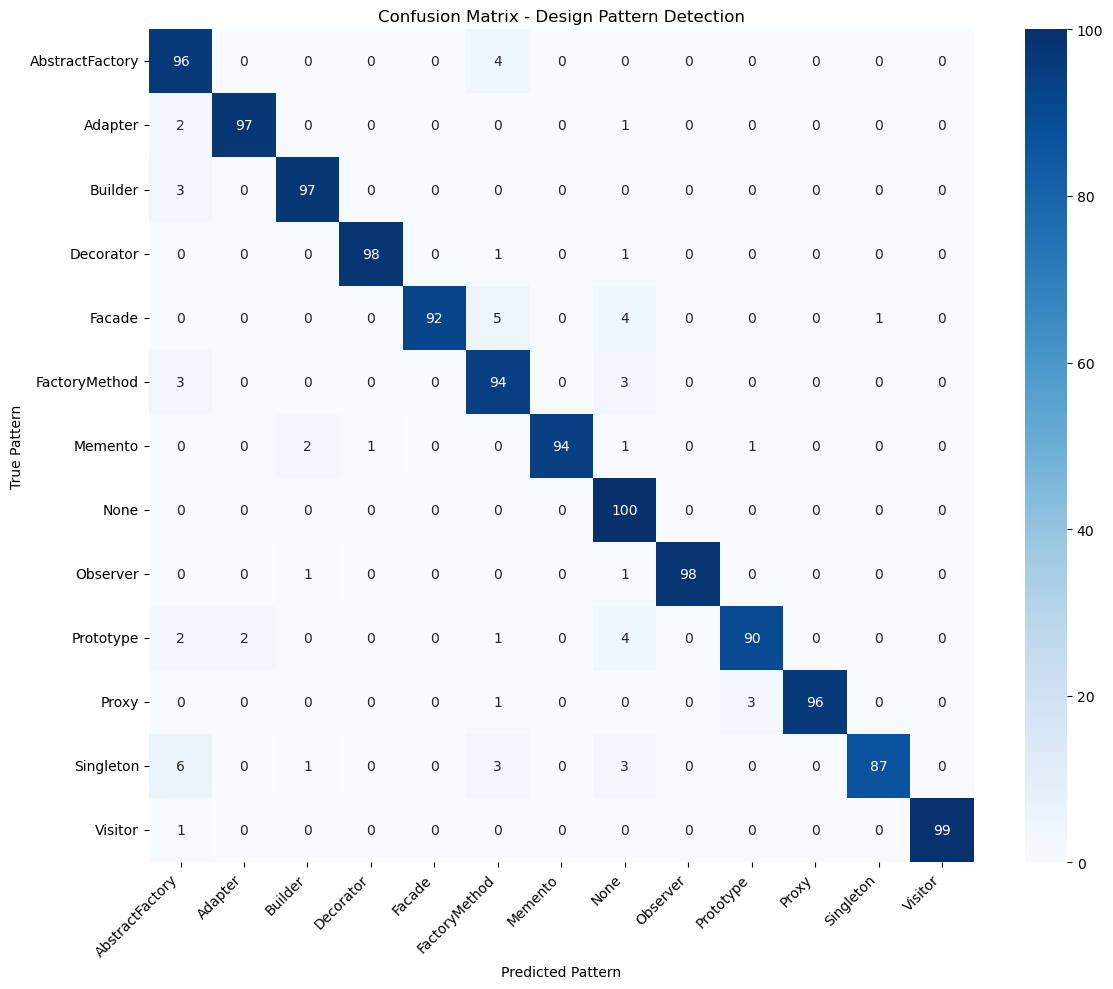

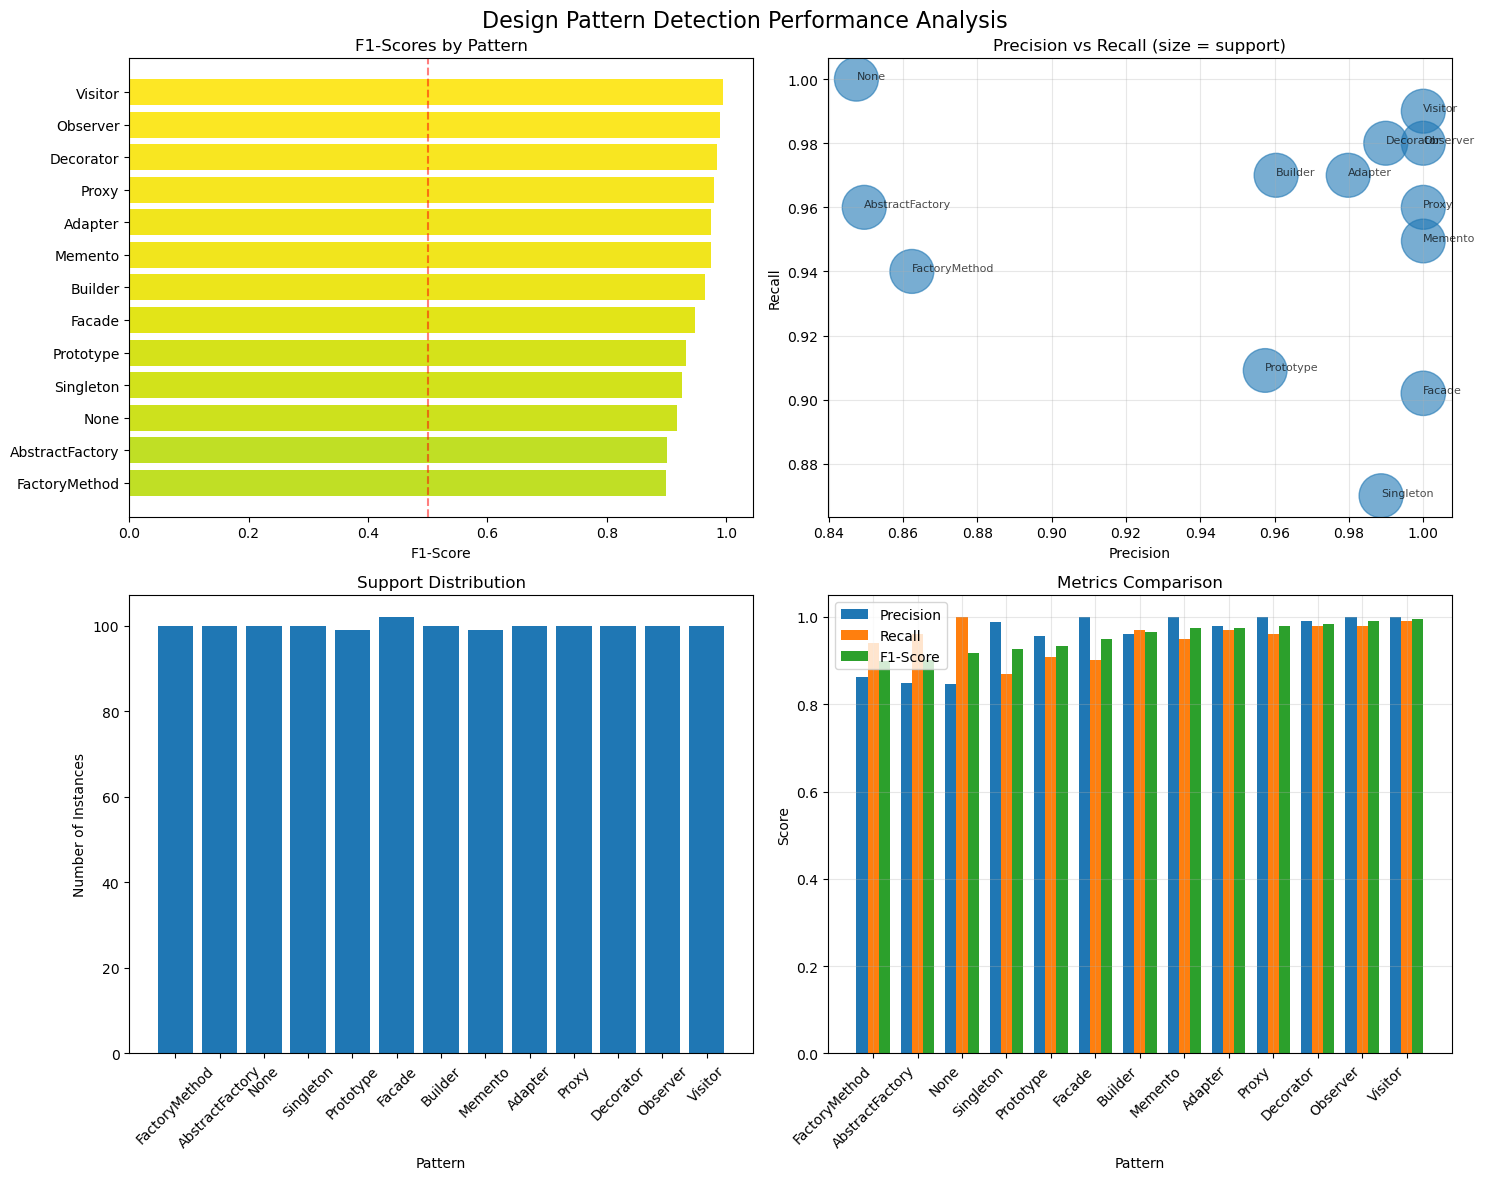

DESIGN PATTERN DETECTION ANALYSIS SUMMARY

📊 OVERALL METRICS:
   Accuracy:  0.952
   Precision: 0.957
   Recall:    0.952
   F1-Score:  0.953
   Samples:   1300

🏆 TOP PERFORMING PATTERNS (by F1-Score):
   1. Visitor              F1: 0.995 (P: 1.000, R: 0.990) Support: 100
   2. Observer             F1: 0.990 (P: 1.000, R: 0.980) Support: 100
   3. Decorator            F1: 0.985 (P: 0.990, R: 0.980) Support: 100
   4. Proxy                F1: 0.980 (P: 1.000, R: 0.960) Support: 100
   5. Adapter              F1: 0.975 (P: 0.980, R: 0.970) Support: 100

⚠️  WORST PERFORMING PATTERNS (by F1-Score):
   1. Prototype            F1: 0.933 (P: 0.957, R: 0.909) Support: 99
   2. Singleton            F1: 0.926 (P: 0.989, R: 0.870) Support: 100
   3. None                 F1: 0.917 (P: 0.847, R: 1.000) Support: 100
   4. AbstractFactory      F1: 0.901 (P: 0.850, R: 0.960) Support: 100
   5. FactoryMethod        F1: 0.900 (P: 0.862, R: 0.940) Support: 100

🔍 TOP 5 MOST COMMON ERRORS:
   1. Singlet

In [51]:
work('deepseek')

             Project                  Class        Pattern Pattern Predicted
0            ChenSun              Statement           None              None
1              dozer  BaseSampleBeanFactory  FactoryMethod     FactoryMethod
2  graph-collections    SpatialIndexVisitor        Visitor           Visitor
3                api      SingletonProvider      Singleton         Singleton
4            thredds          Nc4prototypes      Prototype         Prototype
Total samples analyzed: 1300
Computing overall metrics...

Computing pattern-wise metrics...

Analyzing error types...

Checking for hallucination...

Generating visualizations...


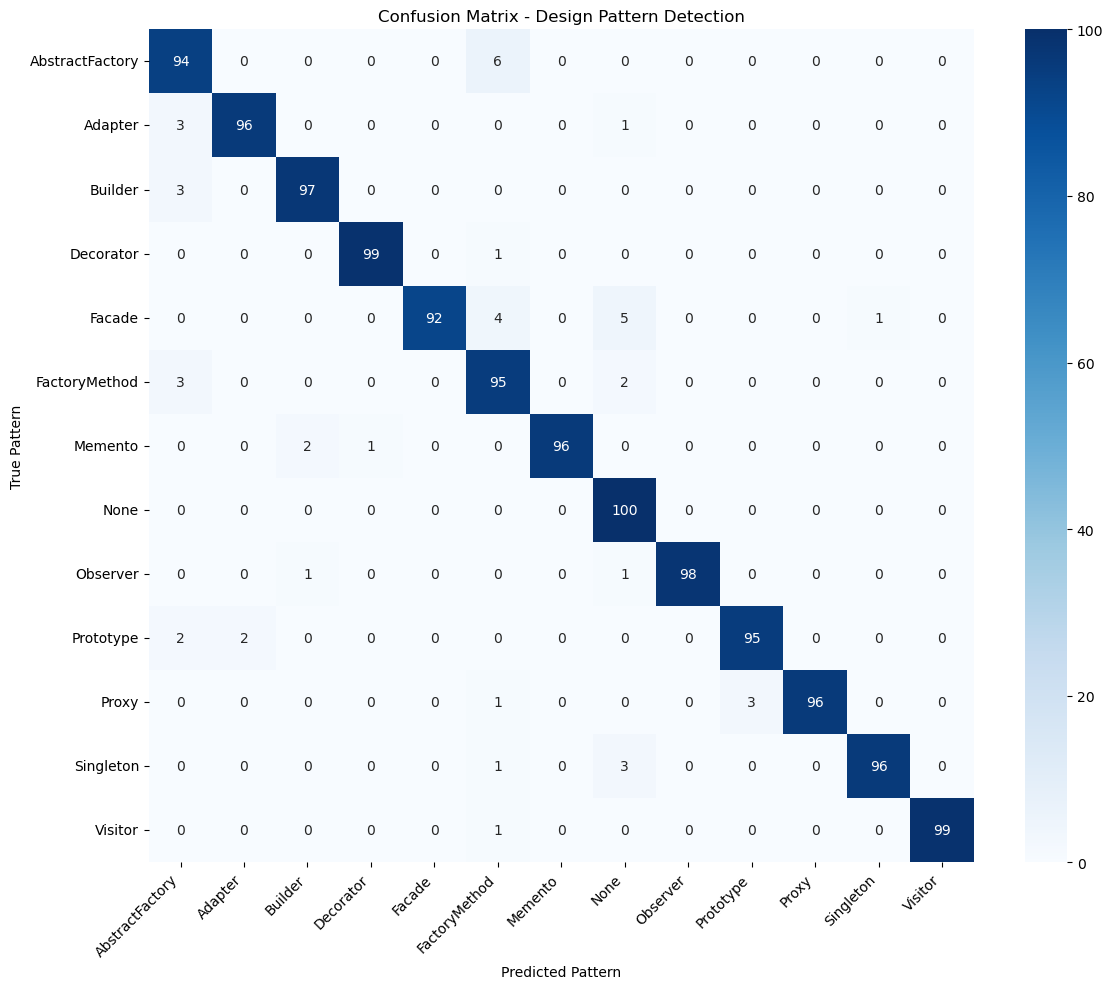

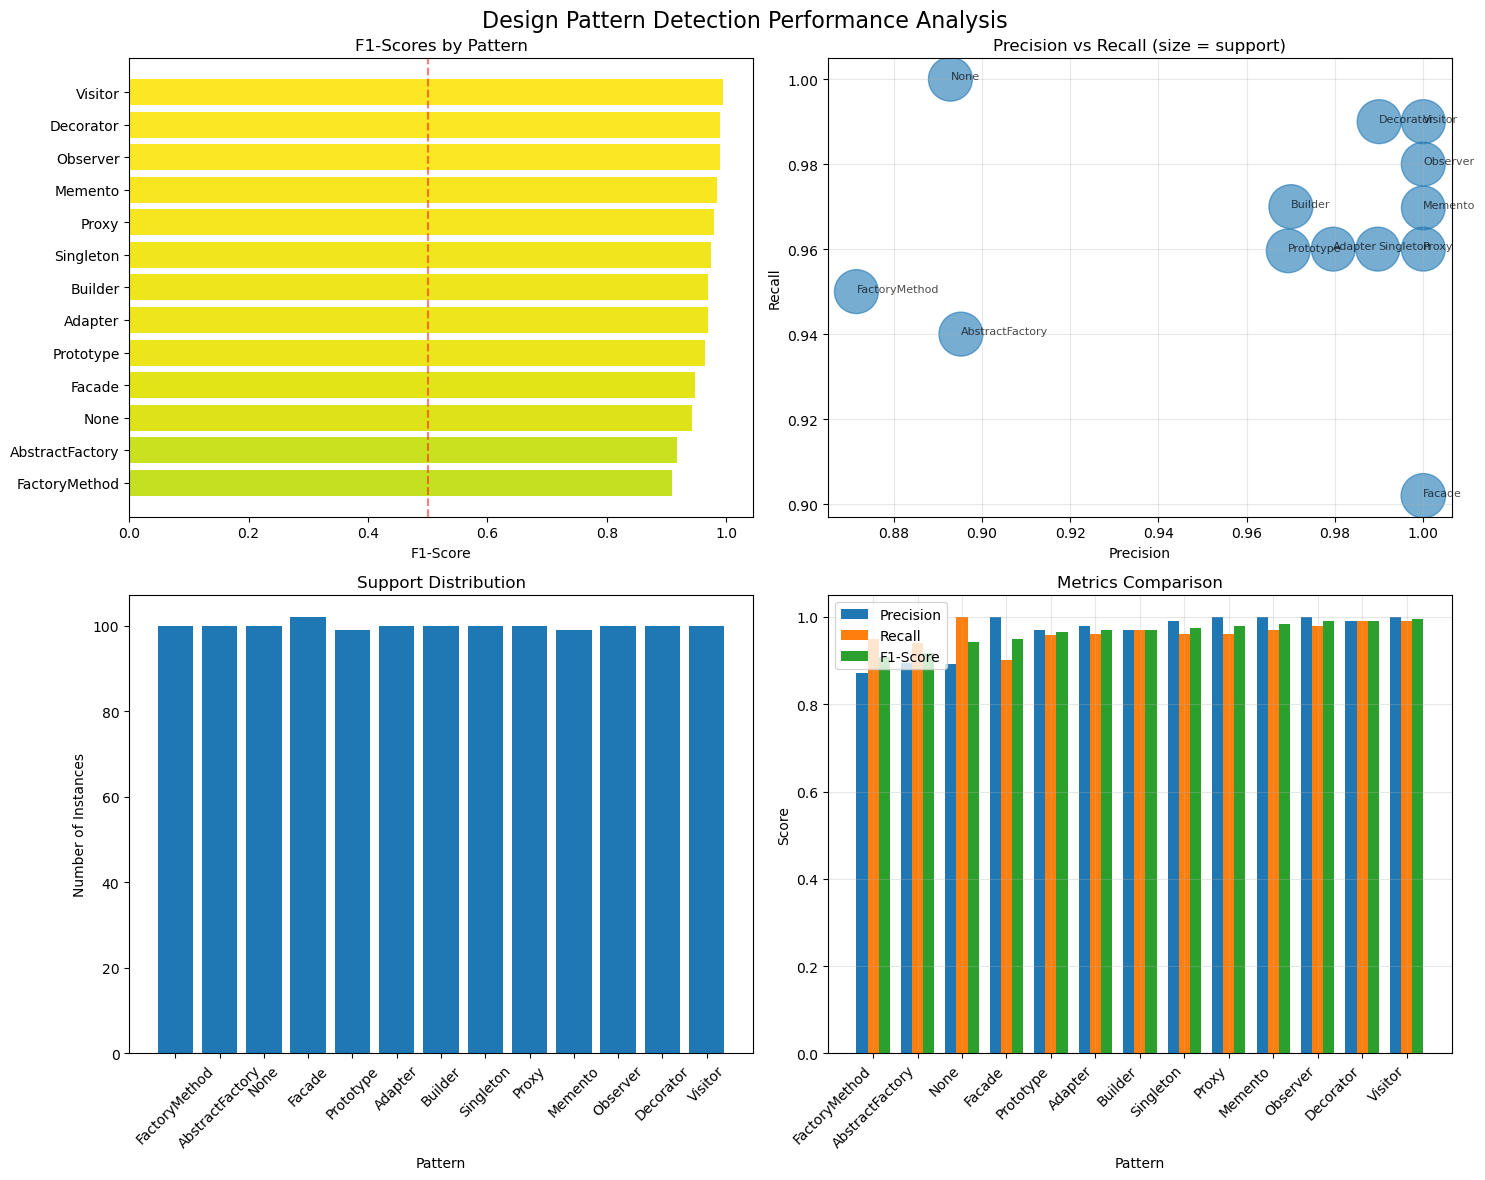

DESIGN PATTERN DETECTION ANALYSIS SUMMARY

📊 OVERALL METRICS:
   Accuracy:  0.964
   Precision: 0.966
   Recall:    0.964
   F1-Score:  0.964
   Samples:   1300

🏆 TOP PERFORMING PATTERNS (by F1-Score):
   1. Visitor              F1: 0.995 (P: 1.000, R: 0.990) Support: 100
   2. Decorator            F1: 0.990 (P: 0.990, R: 0.990) Support: 100
   3. Observer             F1: 0.990 (P: 1.000, R: 0.980) Support: 100
   4. Memento              F1: 0.985 (P: 1.000, R: 0.970) Support: 99
   5. Proxy                F1: 0.980 (P: 1.000, R: 0.960) Support: 100

⚠️  WORST PERFORMING PATTERNS (by F1-Score):
   1. Prototype            F1: 0.964 (P: 0.969, R: 0.960) Support: 99
   2. Facade               F1: 0.948 (P: 1.000, R: 0.902) Support: 102
   3. None                 F1: 0.943 (P: 0.893, R: 1.000) Support: 100
   4. AbstractFactory      F1: 0.917 (P: 0.895, R: 0.940) Support: 100
   5. FactoryMethod        F1: 0.909 (P: 0.872, R: 0.950) Support: 100

🔍 TOP 5 MOST COMMON ERRORS:
   1. Abstract

In [56]:
work('claude')

             Project                  Class        Pattern Pattern Predicted
0            ChenSun              Statement           None              None
1              dozer  BaseSampleBeanFactory  FactoryMethod     FactoryMethod
2  graph-collections    SpatialIndexVisitor        Visitor           Visitor
3                api      SingletonProvider      Singleton         Singleton
4            thredds          Nc4prototypes      Prototype         Prototype
Total samples analyzed: 1300
Computing overall metrics...

Computing pattern-wise metrics...

Analyzing error types...

Checking for hallucination...

Generating visualizations...


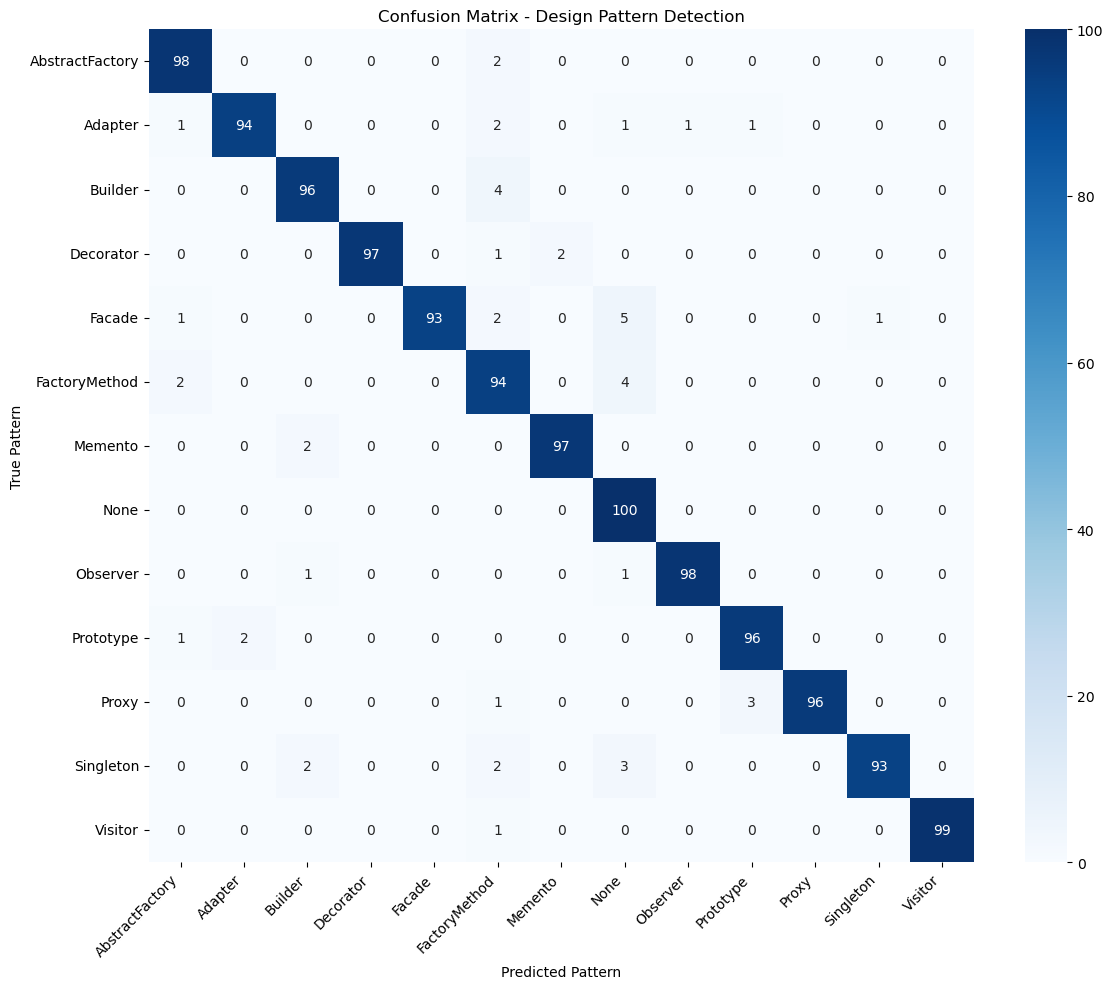

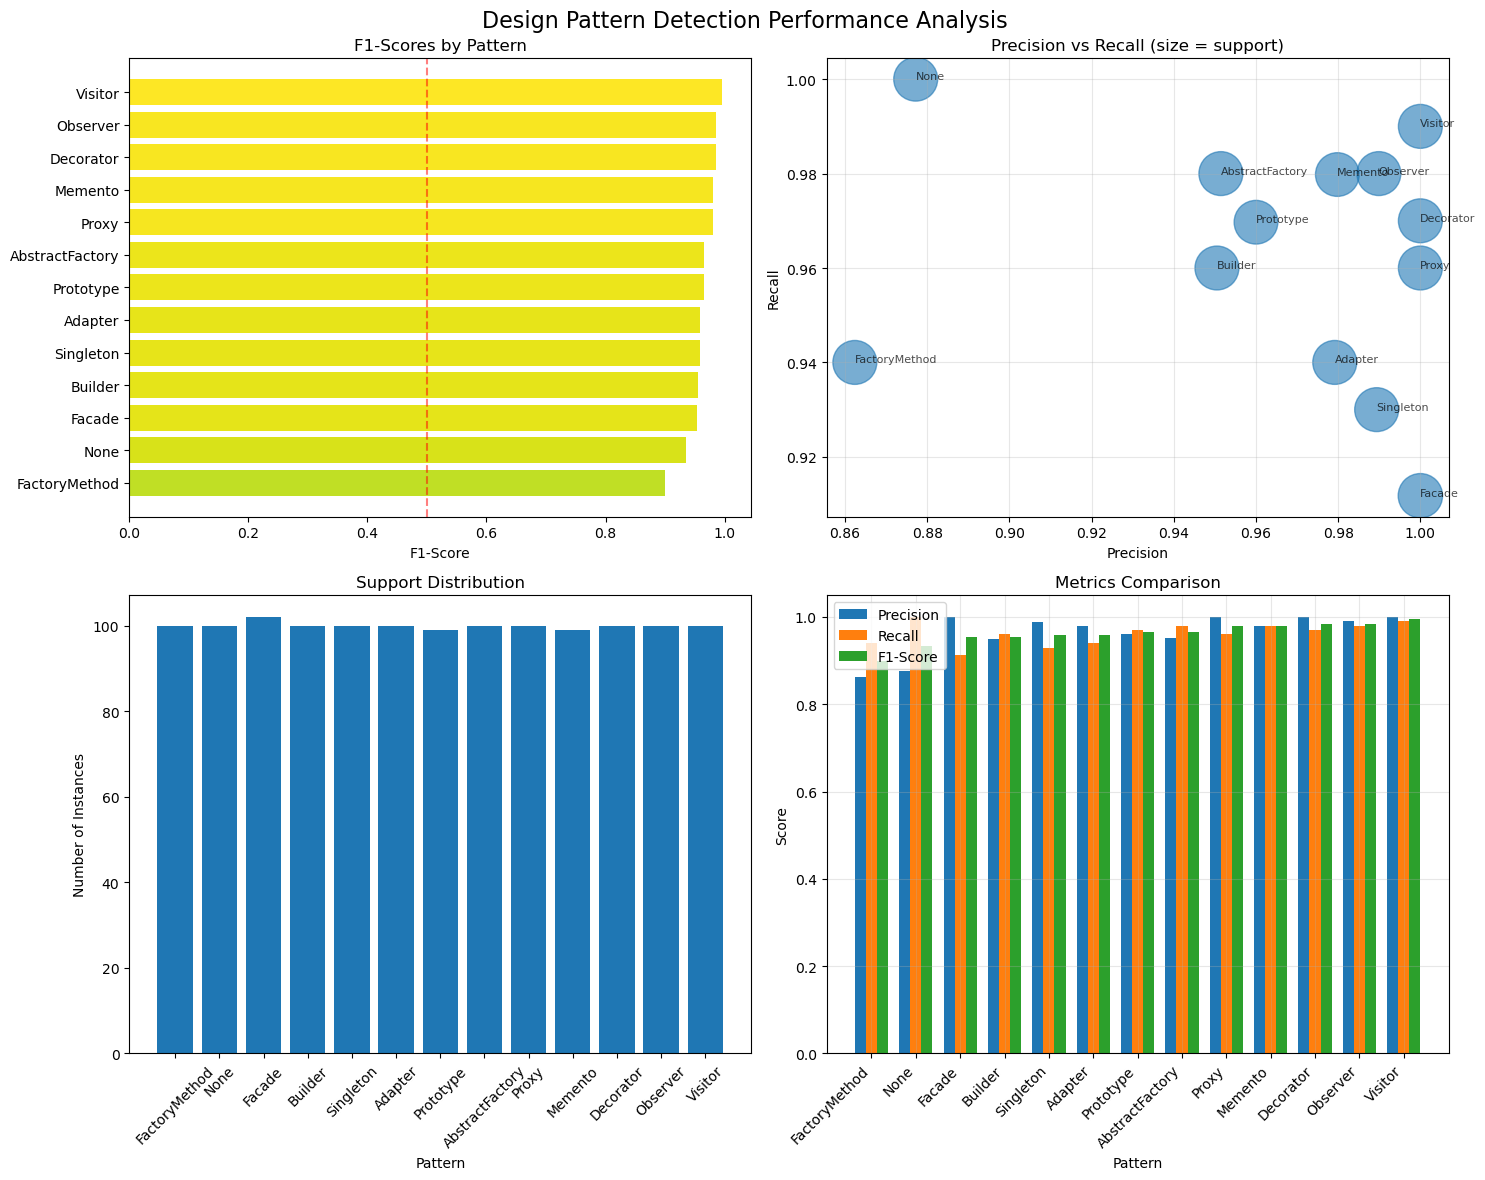

DESIGN PATTERN DETECTION ANALYSIS SUMMARY

📊 OVERALL METRICS:
   Accuracy:  0.962
   Precision: 0.965
   Recall:    0.962
   F1-Score:  0.963
   Samples:   1300

🏆 TOP PERFORMING PATTERNS (by F1-Score):
   1. Visitor              F1: 0.995 (P: 1.000, R: 0.990) Support: 100
   2. Observer             F1: 0.985 (P: 0.990, R: 0.980) Support: 100
   3. Decorator            F1: 0.985 (P: 1.000, R: 0.970) Support: 100
   4. Memento              F1: 0.980 (P: 0.980, R: 0.980) Support: 99
   5. Proxy                F1: 0.980 (P: 1.000, R: 0.960) Support: 100

⚠️  WORST PERFORMING PATTERNS (by F1-Score):
   1. Singleton            F1: 0.959 (P: 0.989, R: 0.930) Support: 100
   2. Builder              F1: 0.955 (P: 0.950, R: 0.960) Support: 100
   3. Facade               F1: 0.954 (P: 1.000, R: 0.912) Support: 102
   4. None                 F1: 0.935 (P: 0.877, R: 1.000) Support: 100
   5. FactoryMethod        F1: 0.900 (P: 0.862, R: 0.940) Support: 100

🔍 TOP 5 MOST COMMON ERRORS:
   1. Facade_

In [58]:
work('gemini')

fig saved!


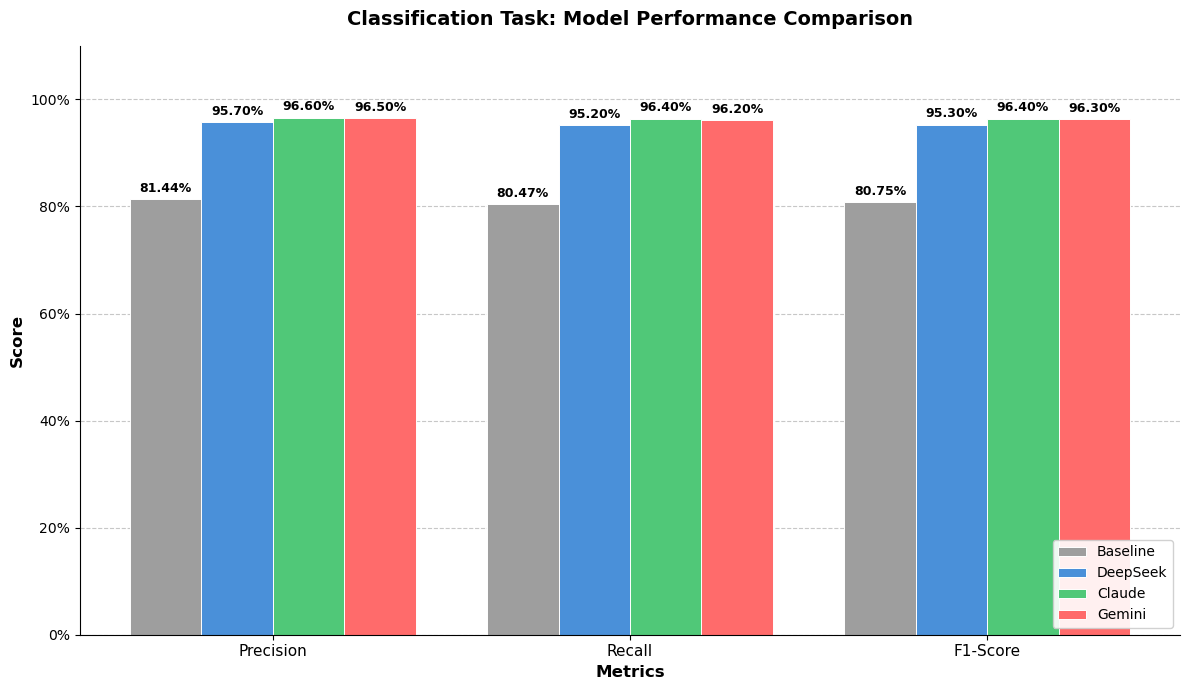

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# exp res data
#accuracy  = [0.952, 0.964, 0.962, ]
precision = [0.8144, 0.957, 0.966, 0.965]
recall    = [0.8047, 0.952, 0.964, 0.962]
f1_score  = [0.8075, 0.953, 0.964, 0.963]

models = ['Baseline(DPD_F)', 'DeepSeek', 'Claude', 'Gemini']

metrics = ['Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.2  

baseline_scores = [precision[0], recall[0], f1_score[0]]
deepseek_scores = [precision[1], recall[1], f1_score[1]]
claude_scores   = [precision[2], recall[2], f1_score[2]]
gemini_scores   = [precision[3], recall[3], f1_score[3]]

fig, ax = plt.subplots(figsize=(12, 7))

colors = ['#9E9E9E', '#4A90D9', '#50C878', '#FF6B6B']  


bars1 = ax.bar(x - 1.5*width, baseline_scores, width, label='Baseline', color=colors[0], edgecolor='white', linewidth=0.7)
bars2 = ax.bar(x - 0.5*width, deepseek_scores, width, label='DeepSeek', color=colors[1], edgecolor='white', linewidth=0.7)
bars3 = ax.bar(x + 0.5*width, claude_scores, width, label='Claude', color=colors[2], edgecolor='white', linewidth=0.7)
bars4 = ax.bar(x + 1.5*width, gemini_scores, width, label='Gemini', color=colors[3], edgecolor='white', linewidth=0.7)

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9, fontweight='bold')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)

ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_title('Classification Task: Model Performance Comparison', fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.set_ylim(0, 1.1)  

ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

ax.legend(loc='lower right', fontsize=10, framealpha=0.9)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig('./Model Performance Comparison.jpg', dpi=150, bbox_inches='tight', facecolor='white')
print("fig saved!")

plt.show()